This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Advanced deep learning for computer vision

## Three essential computer vision tasks

## An image segmentation example

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz      #下載影像資料
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz #對應的分割遮蓋資料
!tar -xf images.tar.gz      #從檔案中提取資料
!tar -xf annotations.tar.gz
#遇到的問題:'wget' 不是內部或外部命令、可執行的程式或批次檔。
#網路上的資料:查到發現wget是linux系統下，windows不自帶。
#解決方法:要在https://eternallybored.org/misc/wget/ 中下載32 or 64位元的EXE檔，並且放到與此資料夾相同之位置

--2022-12-20 09:53:24--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-12-20 09:53:26--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-12-20 09:53:27--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7

In [3]:
!tar -xf images.tar.gz #上面不知道為甚麼這行沒跑到，再次執行就可以了

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [3]:
import tensorflow
print(tensorflow.__version__)
#因為下方一直出現cannot import name 'load_img' from 'tensorflow.keras.utils' (C:\Users\ddwu0\anaconda3\lib\site-packages\tensorflow\keras\utils\__init__.py)
#所以我去找了一夏發現他的用法是2.6之後的版本可以

2.10.1


In [1]:
pip install --upgrade tensorflow-gpu

  Using cached tensorflow_gpu-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Uninstalling absl-py-0.15.0:
      Successfully uninstalled absl-py-0.15.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires absl-py~=0.10, but you have absl-py 1.3.0 which is incompatible.
tensorflow 2.5.0 requires flatbuffers~=1.12.0, but you have flatbuffers 22.12.6 which is incompatible.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.24.1 which is incompatible.
tensorflow 2.5.0 requires tensorflow-estimator<2.6.0,>=2.5.0rc0, but you have tensorflow-estimator 2.10.0 which is incompatible.


In [4]:
import keras
print(keras.__version__)

2.10.0


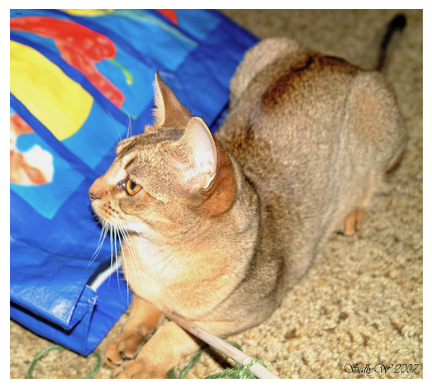

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))#顯示索引9的輸入影像

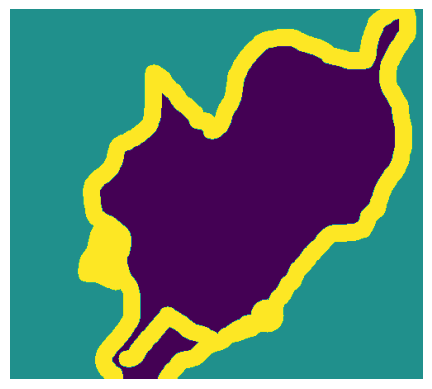

In [5]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127#原本的標籤
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))#將載入的影像視為"單一顏色channel"
display_target(img)

In [6]:
import numpy as np
import random

img_size = (200, 200)#將全部大小改成200*200
num_imgs = len(input_img_paths)#取得資料中的樣本總數

#打亂當初依據品種編排的檔案路徑
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [13]:
#nvidia-smi

NameError: name 'nvidia' is not defined

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=1,
                    validation_data=(val_input_imgs, val_targets))
#Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Epoch 1/50
6390/6390 [==============================] - 1131s 177ms/step - loss: 0.7649 - val_loss: 0.6286
Epoch 2/50
6390/6390 [==============================] - 1080s 169ms/step - loss: 0.6086 - val_loss: 0.5425
Epoch 3/50
6390/6390 [==============================] - 1094s 171ms/step - loss: 0.6224 - val_loss: 0.5933
Epoch 4/50
6390/6390 [==============================] - 2063s 323ms/step - loss: 0.6391 - val_loss: 1.1202
Epoch 5/50
6390/6390 [==============================] - 23859s 4s/step - loss: 0.6655 - val_loss: 0.6393
Epoch 6/50
6390/6390 [==============================] - 1101s 172ms/step - loss: 0.6073 - val_loss: 0.5756
Epoch 7/50
6390/6390 [==============================] - 1093s 171ms/step - loss: 0.6266 - val_loss: 0.5976
Epoch 8/50
6390/6390 [==============================] - 1094s 171ms/step - loss: 0.7785 - val_loss: 0.9301
Epoch 9/50
6390/6390 [==============================] - 1095s 171ms/step - loss: 0.9335 - val_loss: 0.9371
Epoch 10/50
6390/6390 [================

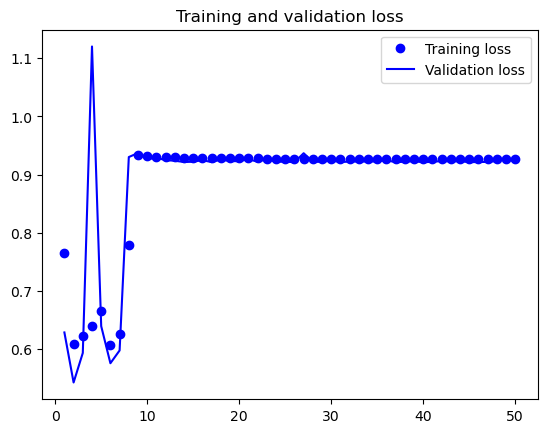

In [9]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 [==============================] - 1s 604ms/step


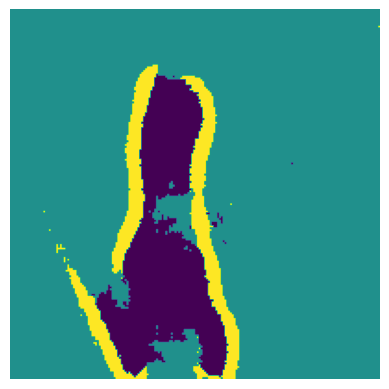

In [10]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)